Notebook to carry out basic statistics on collected data e.g. check distribution of labels, means and variances of features

In [4]:
from unpacking_data import SoberSenseDataset
import os
import json
import sys
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch as t
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import precision_score, recall_score, f1_score

subdirectory_path = os.path.join(os.getcwd(), 'models_and_transforms_v2')
sys.path.append(subdirectory_path)

from data_transforms_v2 import processing_transform, randomly_flipx, randomly_flipy, append_distance, randomly_crop, convert_time_to_intervals, binary_label_transform, append_RT, append_velocity_and_acceleration

device = "cuda" if t.cuda.is_available() else "mps" if t.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

label_name='unitsDrunk'

Using mps device


Checking various screen heights

In [2]:


data = SoberSenseDataset('pilot_data', label_name = label_name, analysing_data=True)

screen_heights = set()
for i in range(len(data)):

    height = data[i][2]["screenHeight"]

    screen_heights.add(height)

print(screen_heights)

{568, 667, 844, 896}


In [5]:

def prep_transform(unprocessed_data):
    x = processing_transform(unprocessed_data)
    x = append_distance(x)
    x, _ = append_RT(x, unprocessed_data, normalising=True)
    x = append_velocity_and_acceleration(x)
    return x

def augmentation_transform(x):
    # x = randomly_flipx(x)
    # x = randomly_flipy(x)
    #x = randomly_crop(x, crop_size= 200)
    return x 

data = SoberSenseDataset('pilot_data', 
                         prep_transform=prep_transform,
                         augmentation_transform=augmentation_transform,
                         analysing_data=True,
                         label_name = label_name)

print("Example shape for one sample:", data[0][0].shape)

# for i in range(len(data)):
#     print("Example shape for one sample:", data[i][0].shape)

Example shape for one sample: torch.Size([9, 1038])


In [7]:
print(data[1][0][-3])

tensor([0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488,
        0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488,
        0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488, 0.5488,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2085, 0.2085, 0.2085,
        0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085,
        0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085,
        0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.2085, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566,
        0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566,
        0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566, 0.1566,
        0.0000, 0.0000, 0.0961, 0.0961, 

First checking distribution of BAC across group 

Amount of counts below drink driving limit: 20
Total number of data points: 45


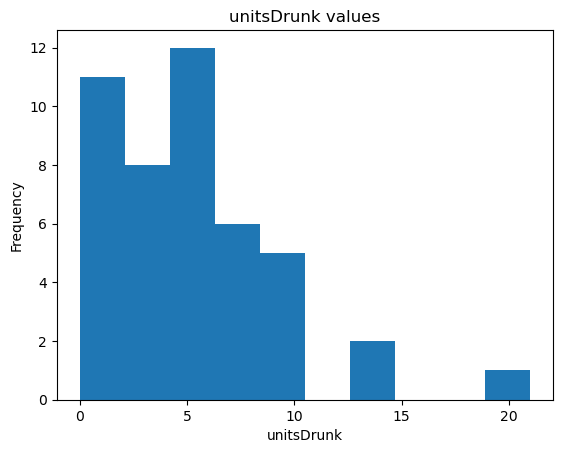

In [4]:
BAC_values = []
below_limit_count = 0
for i in range(len(data)):
    BAC_values.append(data[i][1])

    if data[i][1] < 5:
        below_limit_count += 1


print("Amount of counts below drink driving limit:", below_limit_count)
print("Total number of data points:", len(BAC_values))

plt.hist(BAC_values, bins=10) 

plt.title(f'{label_name} values')
plt.xlabel(f'{label_name}')
plt.ylabel('Frequency')

plt.show()
    


Checking lengths of touch data arrays i.e. the number of touch points recorded for each sample.


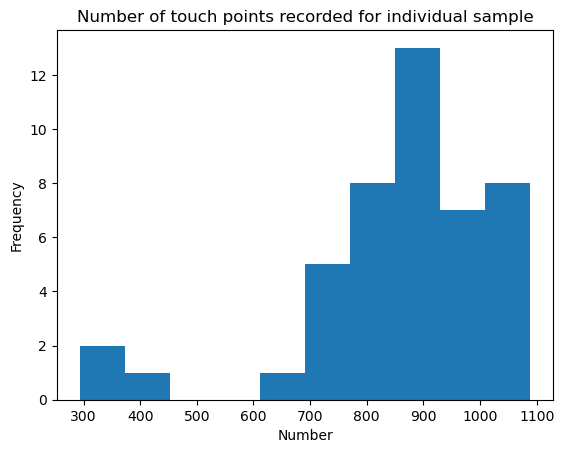

In [8]:
touchpoint_sizes = []
for i in range(len(data)):
    touchpoint_sizes.append(data[i][0].shape[-1])

plt.hist(touchpoint_sizes, bins=10) 

plt.title('Number of touch points recorded for individual sample')
plt.xlabel('Number')
plt.ylabel('Frequency')

plt.show()

Precision: 0.5714285714285714
Recall: 0.7058823529411765
F1 Score: 0.6315789473684211


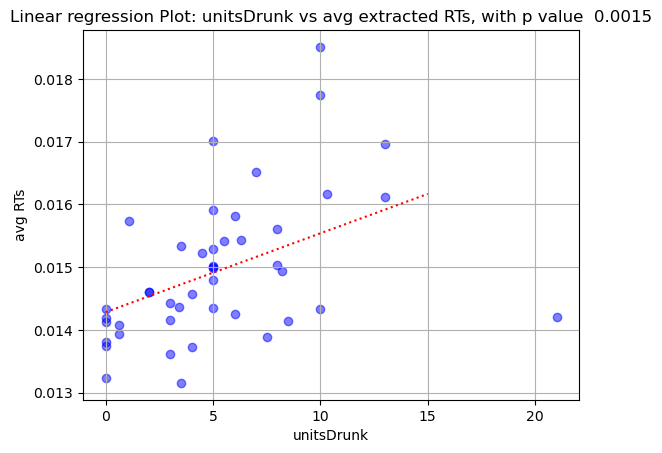

In [5]:

def get_RT_estimate(data_instance, min_RT = 0.01):
    # x touch, x path, y touch, y path, time stamp, distance
    # can make it more sophisticated after first iteration
    
    path_times = data_instance[2]['randomPath']['time']
    RT_list = []
    
    # initial naive solution is just to pluck the peak 
    for i in range(len(path_times)-1):
    
        tmin = path_times[i] + min_RT 
        tmax = path_times[i+1]

        time_mask = (data_instance[0][4] >= tmin) & (data_instance[0][4] <= tmax)

        windowed_data = data_instance[0][4:6, time_mask]

        if windowed_data.shape[-1] != 0:

            index_for_peak_distance = t.argmax(windowed_data[1])

            RT = (windowed_data[0, index_for_peak_distance] - path_times[i]).item()
            
            RT_list.append(RT)

    return RT_list

mean_RTs = []
BAC_values = []
all_RTs = []

for i in range(len(data)):

    RT_list = get_RT_estimate(data[i])
    all_RTs.extend(RT_list)
    mean_RTs.append(sum(RT_list) / len(RT_list))

    BAC_values.append(data[i][1])

slope, intercept, r_value, p_value, std_err = linregress(BAC_values, mean_RTs)

pred_RTs = slope * np.linspace(0, 15, 5) + intercept

plt.scatter(BAC_values, mean_RTs, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 15, 5), pred_RTs, color='red', linestyle=':', label='Fitted Line') 
plt.title(f'Linear regression Plot: {label_name} vs avg extracted RTs, with p value {p_value: .4f}')
plt.xlabel(label_name)
plt.ylabel('avg RTs')
plt.grid(True)


# plt.hist(all_RTs, bins=50)

# how many unit threshold
threshold_units = 5
threshold_RT = slope * threshold_units + intercept

RT_lg_labels = []
true_labels = []

for i in range(len(data)):
    
    if mean_RTs[i] > threshold_RT:
        RT_lg_labels.append(1)
    else:
        RT_lg_labels.append(0)

    if data[i][1] > threshold_units:
        true_labels.append(1)
    else:
        true_labels.append(0)


precision = precision_score(true_labels, RT_lg_labels)
recall = recall_score(true_labels, RT_lg_labels)
f1 = f1_score(true_labels, RT_lg_labels)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")




May be worth cutting off any data samples below a count of 500, as they may be badly recorded. Having checked the source of these, it's NOT consistently from one tester or phone.


Checking how distance between touch point and circle changes across all data samples.

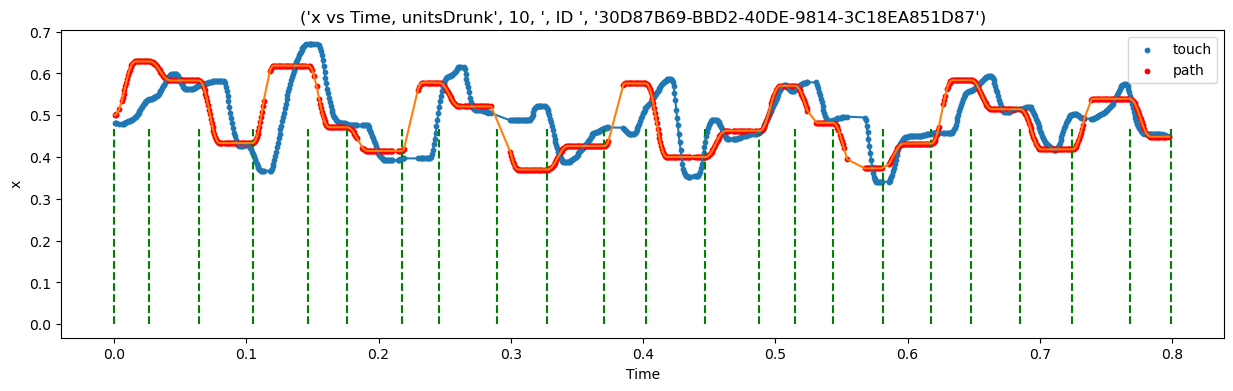

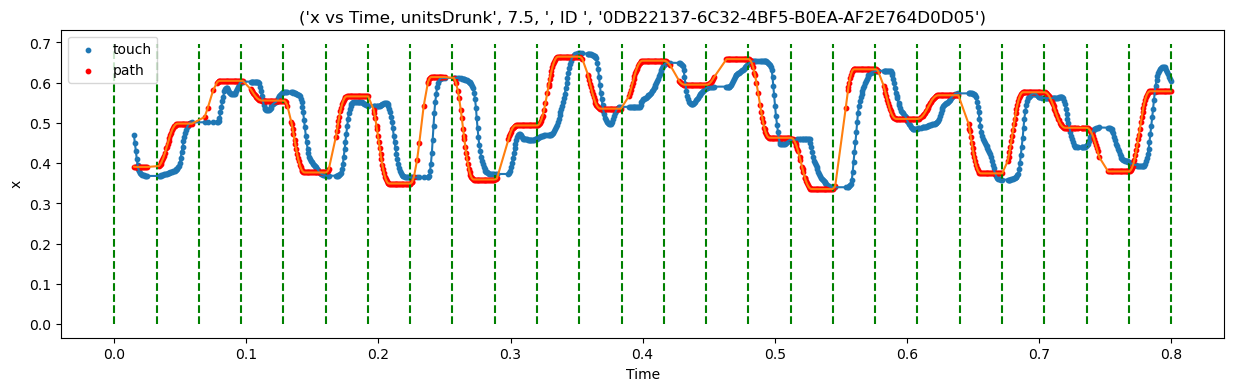

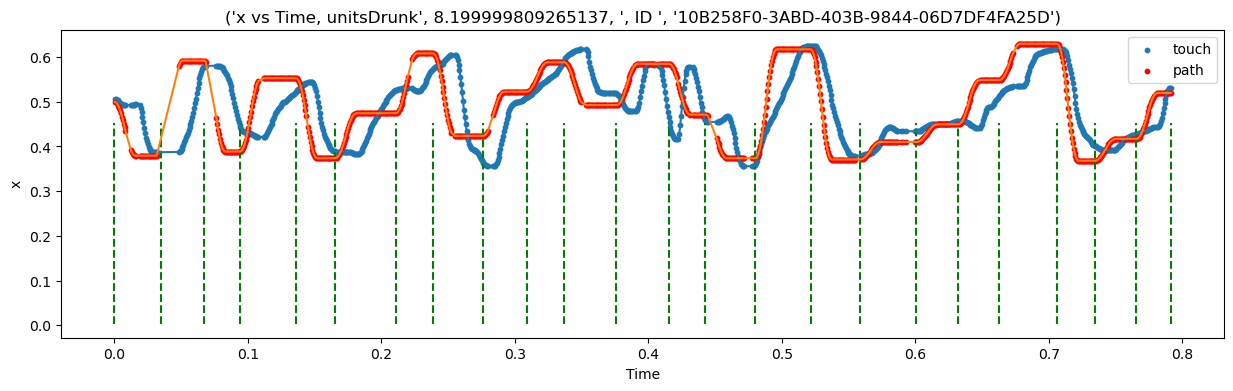

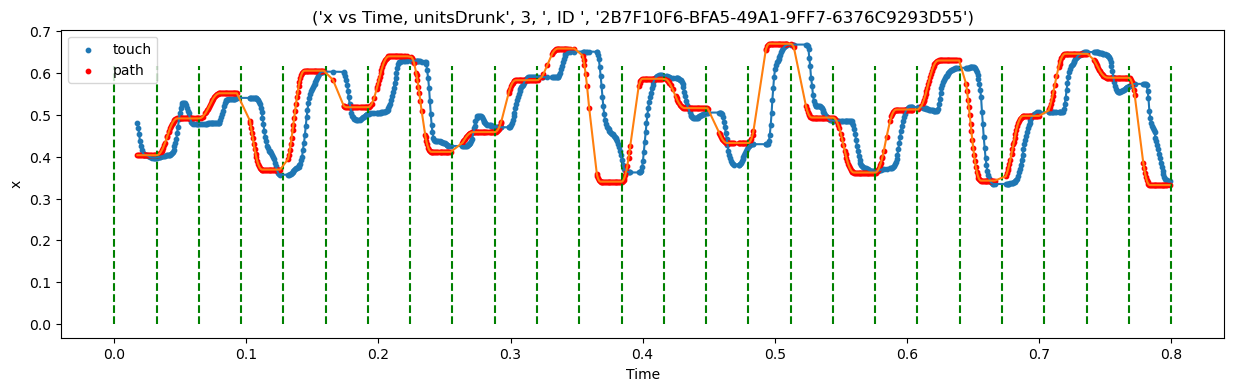

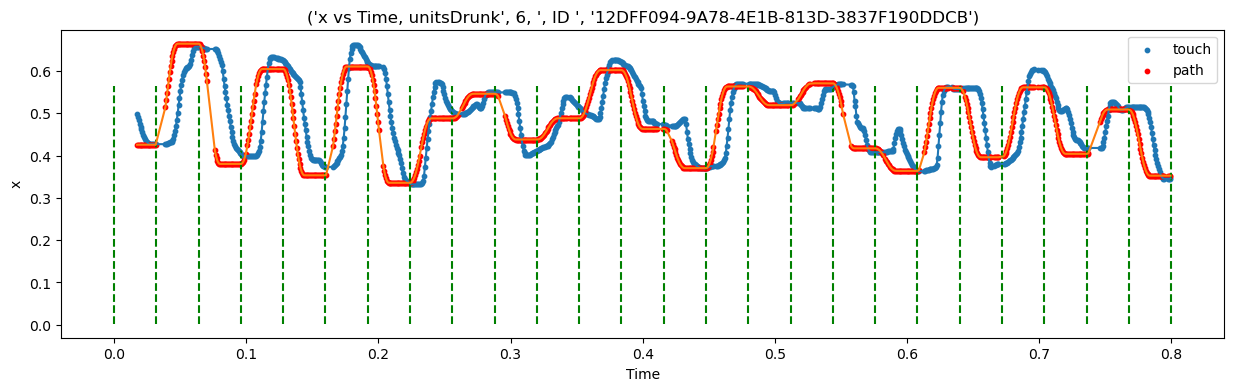

In [10]:

# Shape of sample is [num_features, p]
# features: x_touch, x_path, y_touch, y_path, time, distance

plot_RT = False
feature_to_plot = 'x'

# just printing a sample 
for i in range(0, len(data), 10):

    single_instance = data[i][0].cpu().numpy()
    bac = data[i][1]

    times = single_instance[4, :]
    distances = single_instance[5, :]

    touch_x = single_instance[0, :]
    path_x = single_instance[1, :]

    touch_y = single_instance[2, :]
    path_y = single_instance[3, :]

    path_change_times = data[i][2]['randomPath']['time']

    plt.figure(i, figsize=(15, 4))

    for time in path_change_times:
        plt.vlines(time, ymin=min(distances), ymax=max(distances), colors='green', linestyles = 'dashed')

    # won't work with cropping augmentation
    if plot_RT:
        RT_times = get_RT_estimate(data[i])

        for j in range(len(RT_times)):
            time = RT_times[j] + path_change_times[j]
            plt.vlines(time, ymin=min(distances), ymax=max(distances), colors='orange', linestyle='-.')


    if feature_to_plot == 'dist':
        plt.plot(times, distances)
        plt.scatter(times, distances, color='red', marker='o', s=10)
    elif feature_to_plot == 'x':
        plt.plot(times, touch_x)
        plt.scatter(times, touch_x, marker='o', label='touch', s=10)
        plt.plot(times, path_x)
        plt.scatter(times, path_x, color='red', marker='o', label='path', s=10)
    elif feature_to_plot == 'y':
        plt.plot(times, touch_y)
        plt.scatter(times, touch_y, marker='o', label='touch', s=10)
        plt.plot(times, path_y)
        plt.scatter(times, path_y, color='red', marker='o', label='path', s=10)

    plt.legend()

    
    plt.xlabel('Time')
    plt.ylabel(feature_to_plot)
    
    id = data[i][3]

    plt.figure(i, figsize=(15, 4))


    plt.title((f'{feature_to_plot} vs Time, {label_name}', bac, ", ID ", id))
    plt.show()

Checking average distance (between touch point and circle) vs BAC

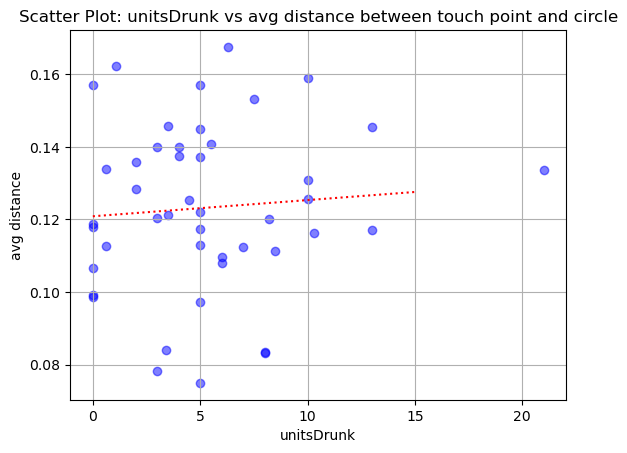

p-value: 0.594373581856912


In [5]:
mean_distances = []
BAC_values = []

for i in range(len(data)):

    distances = data[i][0][5, :].cpu().numpy()

    mean_distances.append(np.mean(distances))

    BAC_values.append(data[i][1])


slope, intercept, r_value, p_value, std_err = linregress(BAC_values, mean_distances)


pred_distances = slope * np.linspace(0, 15, 5) + intercept

plt.scatter(BAC_values, mean_distances, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 15, 5), pred_distances, color='red', linestyle=':', label='Fitted Line') 
plt.title(f'Scatter Plot: {label_name} vs avg distance between touch point and circle')
plt.xlabel(label_name)
plt.ylabel('avg distance')
plt.grid(True)


plt.show()
print("p-value:", p_value)

Checking velocity of touch movement



In [6]:
all_accelerations = []
all_velocities = []

for i in range(0, len(data)):
    velocities =  data[i][0][6, :].cpu().numpy()
    accelerations = data[i][0][7, :].cpu().numpy()

    all_accelerations.extend(accelerations)
    all_velocities.extend(velocities)

mean_velocity = np.mean(all_velocities)
var_velocity = np.var(all_velocities)
median_velocity = np.median(all_velocities)
iqr_velocity = np.percentile(all_velocities, 75) - np.percentile(all_velocities, 25)
maxclip_velocity = np.percentile(all_velocities, 99)
minclip_velocity = np.percentile(all_velocities, 1)

mean_acc = np.mean(all_accelerations)
var_acc = np.var(all_accelerations)
median_acc = np.median(all_accelerations)
iqr_acc = np.percentile(all_accelerations,75) - np.percentile(all_accelerations,25)
maxclip_acceleration = np.percentile(all_accelerations, 99)
minclip_acceleration = np.percentile(all_accelerations, 1)

# acceleration velocity normalising values 
av_normalising_values = {"min_cv": minclip_velocity,
                         "max_cv": maxclip_velocity,
                         "max_ca": maxclip_acceleration,
                         "min_ca": minclip_acceleration}


with open('av_normalising_values.json', 'w') as file:
    json.dump(av_normalising_values, file)



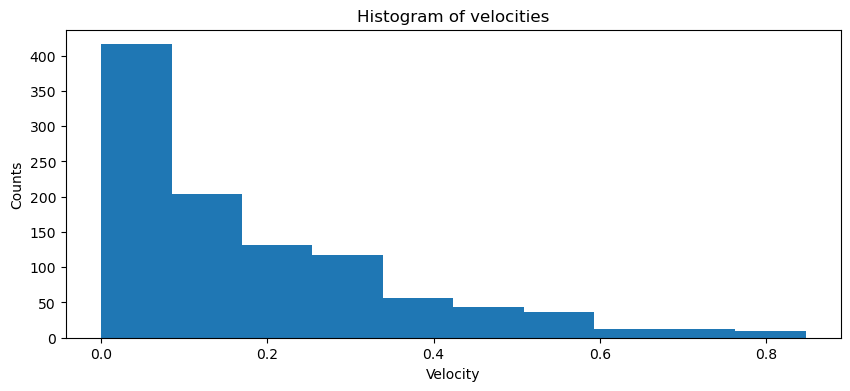

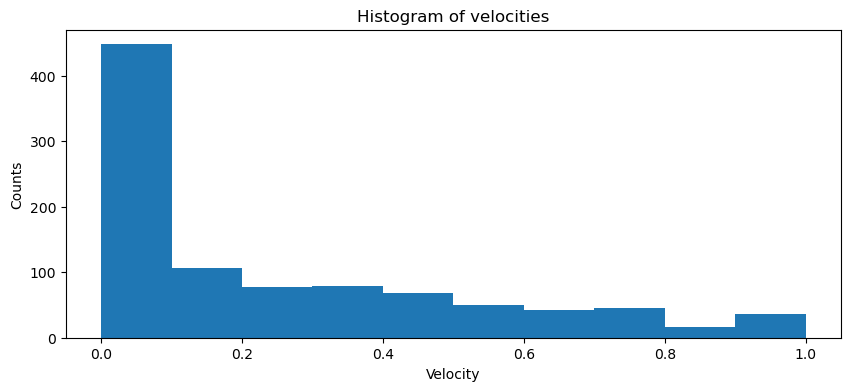

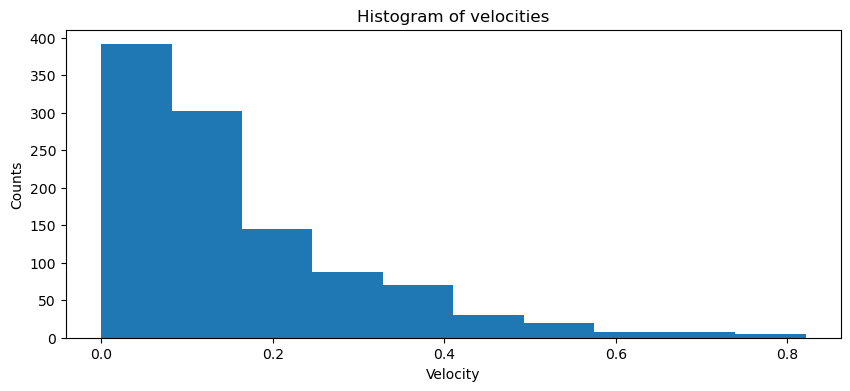

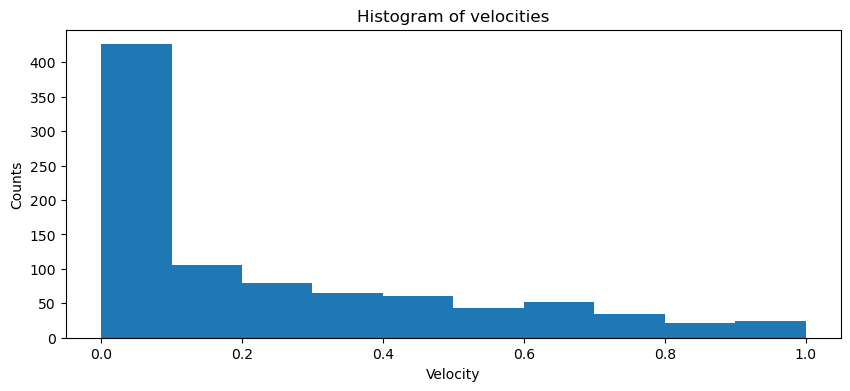

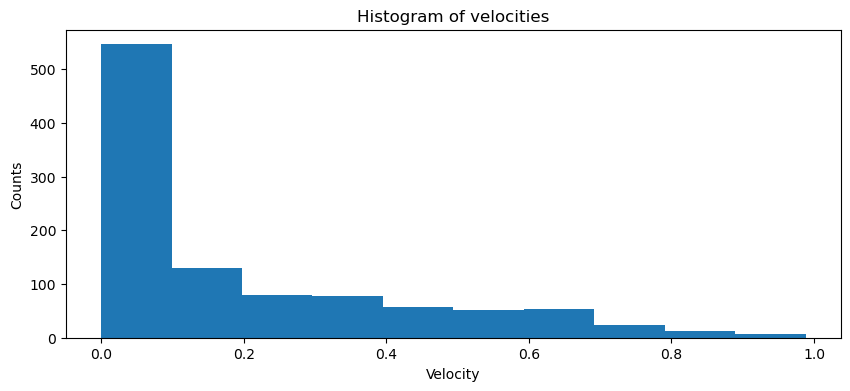

array([], dtype=float32)

In [30]:
for i in range(0, len(data), 10):

    times = data[i][0][4, :].cpu().numpy()
    velocities = data[i][0][6, :].cpu().numpy()

    # offset avoids log(0)
    offset = 1e-6 
    log_velocities = np.log(velocities + offset)

    plt.figure(i, figsize=(10, 4))

    #normalised_velocities = (velocities - median_velocity) / iqr_velocity

    normalised_velocities = np.clip(velocities, minclip_velocity, maxclip_velocity)
    normalised_velocities = (normalised_velocities - minclip_velocity) / (maxclip_velocity-minclip_velocity)

    #plt.plot(times, velocities)
    #plt.scatter(times, velocities, color='red', marker='o', label='Scatter Plot', s=10)
    # plt.xlabel('Time')
    # plt.ylabel('Distance')
    # plt.title('Velocity of touch point')

    plt.hist(normalised_velocities, bins = 10)
    plt.xlabel("Velocity")
    plt.ylabel("Counts")
    plt.title("Histogram of velocities")
    
    plt.show()

normalised_velocities[normalised_velocities < 0]

all_velocities = np.array(all_velocities)
all_velocities[all_velocities < 0]

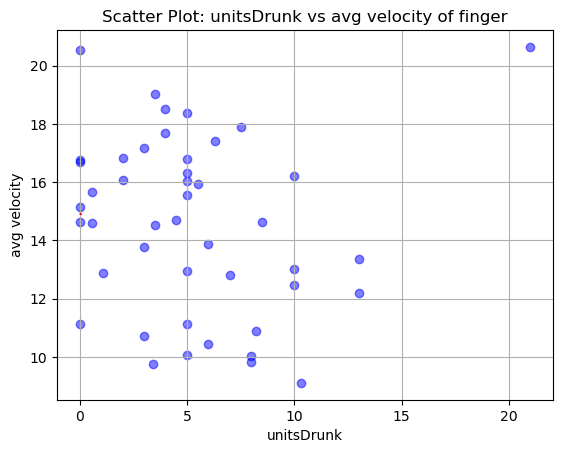

In [5]:
mean_velocity = []
BAC_values = []

for i in range(len(data)):

    velocities = data[i][0][6, :].cpu().numpy()
    mean_velocity.append(np.mean(velocities))

    BAC_values.append(data[i][1])


m, b = np.polyfit(BAC_values, mean_velocity, 1)

pred_velocities = m * np.linspace(0, 0.25, 5) + b

plt.scatter(BAC_values, mean_velocity, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 0.25, 5), pred_velocities, color='red', linestyle=':', label='Fitted Line') 
plt.title(f'Scatter Plot: {label_name} vs avg velocity of finger')
plt.xlabel(label_name)
plt.ylabel('avg velocity')
plt.grid(True)

plt.show()

Checking acceleration of finger

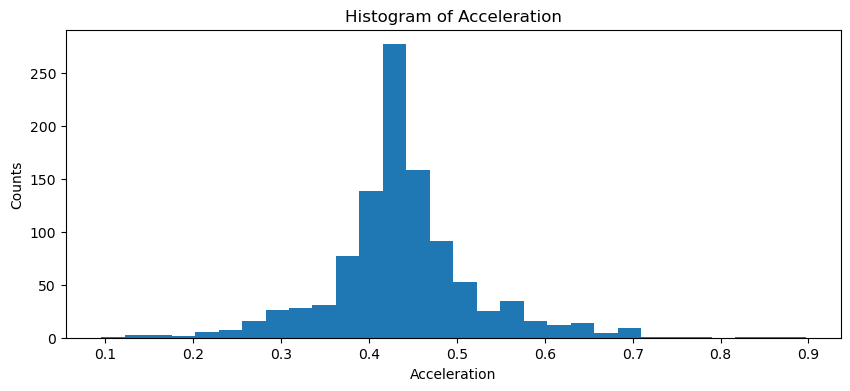

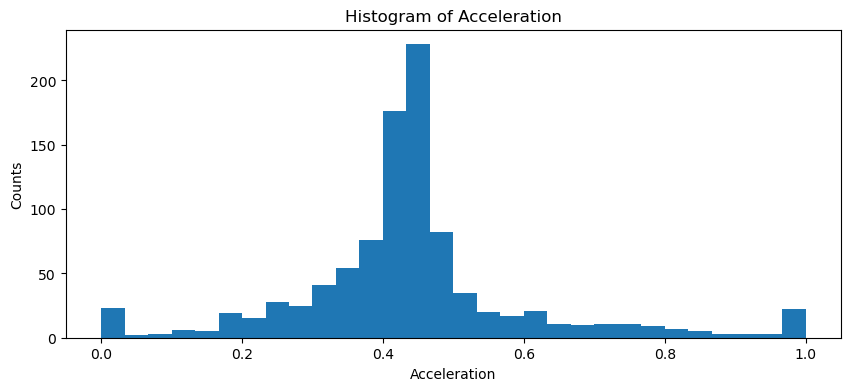

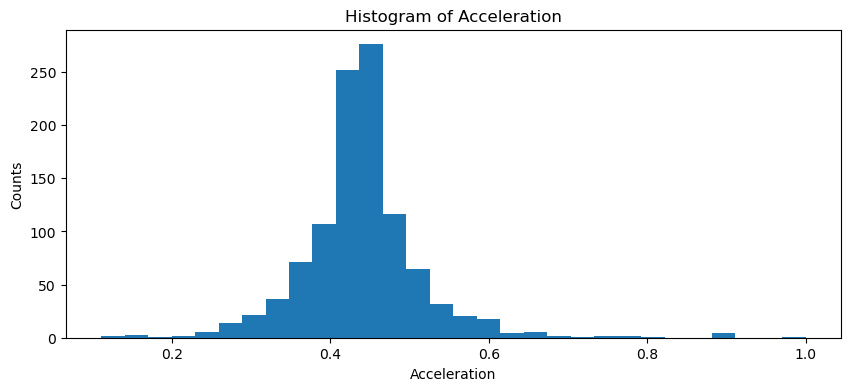

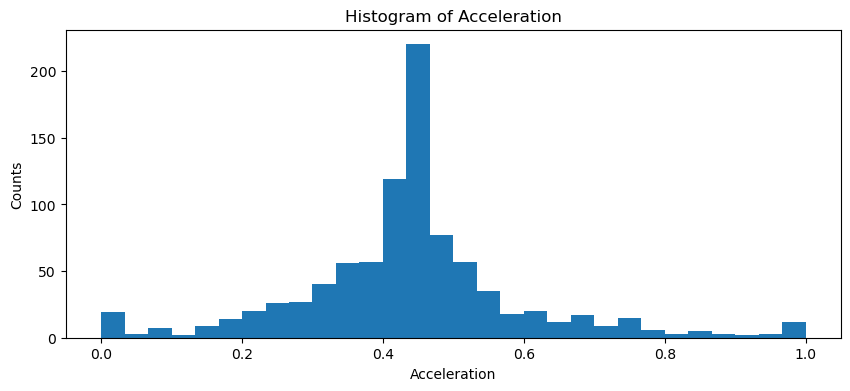

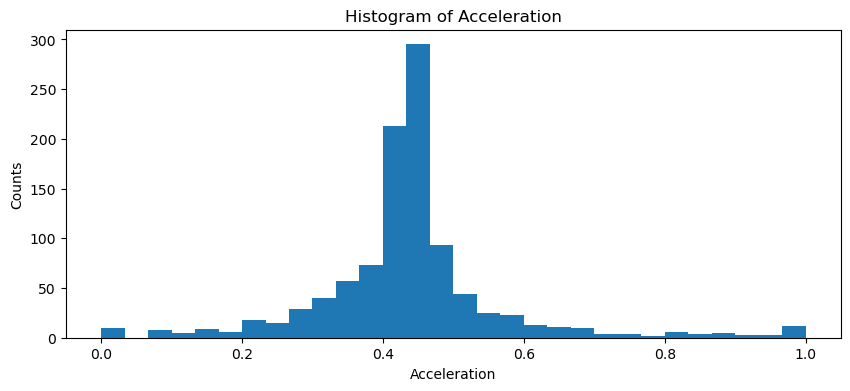

In [27]:

for i in range(0, len(data), 10):

    times = data[i][0][4, :].cpu().numpy()
    accelerations = data[i][0][7, :].cpu().numpy()


    plt.figure(i, figsize=(10, 4))
    
    # plt.plot(times, accelerations)
    # plt.scatter(times, accelerations, color='red', marker='o', label='Scatter Plot', s=10)
    # plt.xlabel('Time')
    # plt.ylabel('Distance')
    # plt.title('Acceleration of touch point')

    # appearing much like normal distribution, so consider normalising with that?
    # median acceleration seems much less applicable
    # 
    #
    
    #normalised_acceleration = (accelerations - median_acc) / iqr_acc

    normalised_acceleration = np.clip(accelerations, minclip_acceleration, maxclip_acceleration)
    normalised_acceleration = (normalised_acceleration - minclip_acceleration) / (maxclip_acceleration - minclip_acceleration)

    plt.hist(normalised_acceleration, bins = 30)
    plt.xlabel("Acceleration")
    plt.ylabel("Counts")
    plt.title("Histogram of Acceleration")


    plt.show()


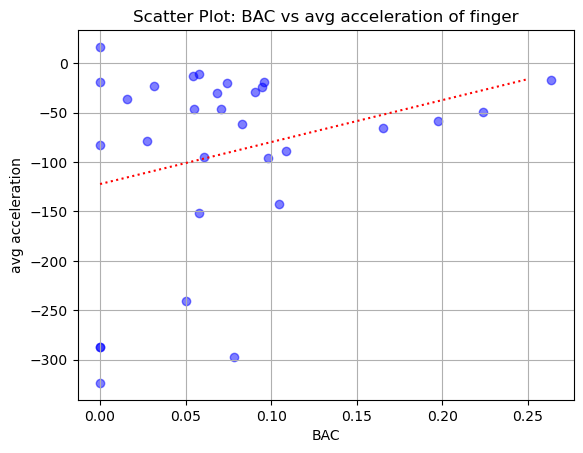

In [33]:
mean_acc = []
BAC_values = []

for i in range(len(data)):

    accelerations = data[i][0][7, :].cpu().numpy()
    mean_acc.append(np.mean(accelerations))

    BAC_values.append(data[i][1])


m, b = np.polyfit(BAC_values, mean_acc, 1)

pred_acc = m * np.linspace(0, 0.25, 5) + b

plt.scatter(BAC_values, mean_acc, color='blue', alpha=0.5)
plt.plot(np.linspace(0, 0.25, 5), pred_acc, color='red', linestyle=':', label='Fitted Line') 
plt.title('Scatter Plot: BAC vs avg acceleration of finger')
plt.xlabel('BAC')
plt.ylabel('avg acceleration')
plt.grid(True)


plt.show()